# Rebalancing Frequency

Group 5, Math Methods in Financial Economics

In order to determine the appropriate frequency for rebalancing a portfolio to correct for drift, we use past porfolio performance and Monte Carlo simulation to consider different rebalancing timesteps.

## Examine Mutual Fund Data

Import fund data from Yahoo!Finance, clean, and plot.

In [1]:
#import data
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1999, 1, 1)
end = datetime.datetime(2017, 1, 1)

VEIEX = web.DataReader("VEIEX", 'yahoo', start, end) #emerging markets
VGSIX = web.DataReader("VGSIX", 'yahoo', start, end) #real estate investment trusts
VISVX = web.DataReader("VISVX", 'yahoo', start, end) #small cap value
VIVAX = web.DataReader("VIVAX", 'yahoo', start, end) #value index (large)
VIMSX = web.DataReader("VIMSX", 'yahoo', start, end) #mid cap
VIGRX = web.DataReader("VIGRX", 'yahoo', start, end) #growth index (large)
VISGX = web.DataReader("VISGX", 'yahoo', start, end) #small cap growth
VEURX = web.DataReader("VEURX", 'yahoo', start, end) #European
VPACX = web.DataReader("VPACX", 'yahoo', start, end) #Pacific
VBISX = web.DataReader("VBISX", 'yahoo', start, end) #short term government bonds

In [2]:
#concatenate data
funds = [VEIEX, VGSIX, VISVX, VIVAX, VIMSX, VIGRX, VEURX, VPACX, VBISX]
fundnames = ["VEIEX", "VGSIX", "VISVX", "VIVAX", "VIMSX", "VIGRX", "VEURX", "VPACX", "VBISX"]

for k in range(0,len(fundnames)):
    funds[k] = funds[k].drop(["Open", "High", "Low", "Close", "Volume"],1)
    funds[k] = funds[k].rename(index=str, columns={"Adj Close":fundnames[k]})

history = pd.concat(funds, axis=1)
history.index = history.index.to_datetime()

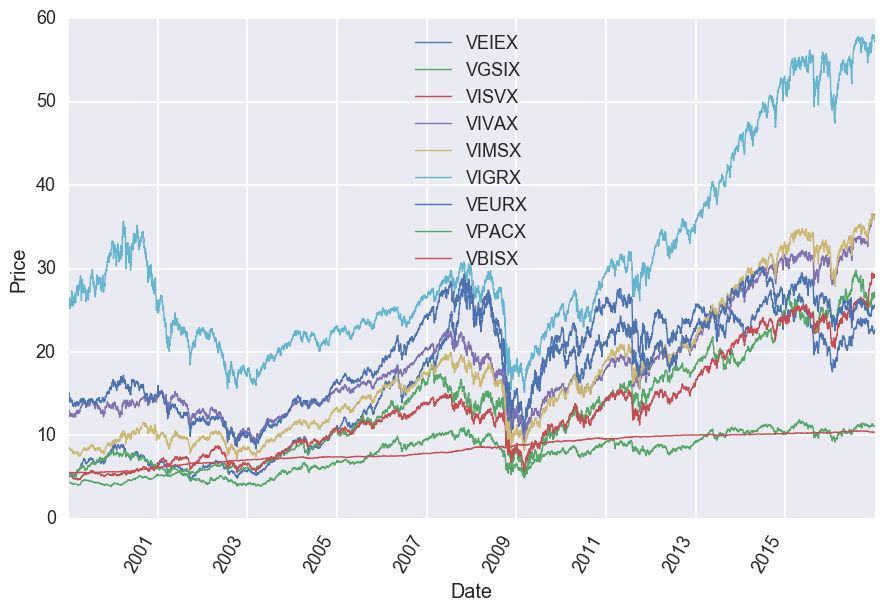

In [3]:
#plot data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("talk", rc={"lines.linewidth": 1})
history.plot(rot=60)
plt.xlabel('Date')
plt.ylabel('Price')

## Calculate Returns and Volatility for Each Stock

In [4]:
#This section is adapted from Gouthaman Balaraman
import numpy as np

fundinfo = np.zeros((len(history.columns), 2))

for k in range(0,len(history.columns)):
    df=history[fundnames[k]]

    # create a time-series of monthly data points
    rsmp = df.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()
    covmat = np.cov(rts)

    # 5 - year volatility
    volatility = np.sqrt(covmat)

    # annualize the numbers
    prd = 12. # used monthly returns; 12 periods to annualize
    volatility = volatility*np.sqrt(prd)

    av_ret = rts.mean()
    
    fundinfo[k,0] = av_ret
    fundinfo[k,1] = volatility
    
fundstats = pd.DataFrame({'avg yr return' : fundinfo[:,0], '5 yr volatility' : fundinfo[:,1]}, index = [fundnames] )

## Risk Aversion Calculation

Construct a utility function and calculate risk aversion $\gamma$.

In [ ]:
#code

## Stock/Bond Split

Calculate $k_b$ and $k_s$ based on the individual's risk aversion.

In [7]:
#code

## Optimal Portfolio

Find $\mu$ and $\sigma$ of the optimal portfolio

## Rebalancing Frequency

### Historical Performance

Use past stock data to compare different rebalancing timesteps: minute, hour, day, month, year.

In [5]:
# dummy stock/bond splits
ksi = 0.8
kbi = 1-ksi

kmat = np.zeros((len(history.index),(len(fundnames))))
kinit = np.zeros(len(fundnames))
kinit[len(fundnames)-1] = kbi
kinit[0] = 0.35
kinit[1] = 0.1
kinit[2] = 0.1
kinit[4] = 0.1
kinit[3] = 0.15

#initialize wealth array
W = np.zeros((len(history.index),4))

for j in [0,1,2,3]:
    i = 0
    on = True
    if j==0:
        a = history.resample('D').first() #daily rebalance
    elif j==1:
        a = history.resample('MS').first() #monthly rebalance
    elif j==2:
        a = history.resample('AS').first() #yearly rebalance
    elif j==3:
        on = False
    
    #initial number of shares of each stock
    W_init = 1000 #dollars
    delta = np.divide(kinit*W_init,history.iloc[0].values)

    for k in range(0,len(kmat)):
        W_ind = np.multiply(delta,history.iloc[k].values)
        W[k,j] = W_ind.sum()
        kmat[k,:] = np.multiply(history.iloc[k], delta/W[k,j])
    
        if on == True and i<=len(a.index)-1 and (history.index[k].year*10000000 + history.index[k].month*1000 + history.index[k].day) >= (a.index[i].year*10000000 + a.index[i].month*1000 + a.index[i].day):
            delta = np.divide(kinit*W[k,j], history.iloc[k])
            i += 1

Daily Rebalancing: $4184.84 
Monthly Rebalancing: $4120.92 
Yearly Rebalancing: $4362.86 
No Rebalancing: $3885.32


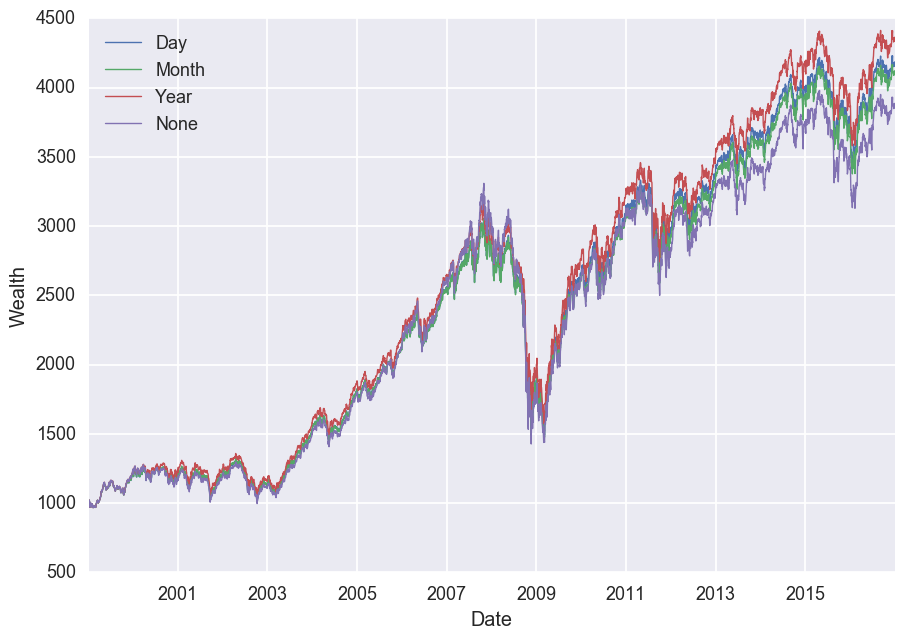

In [6]:
#print results
plt.plot(history.index,W)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend(['Day', 'Month', 'Year', 'None'], loc = 0)
print('Daily Rebalancing: ${0:.2f} \nMonthly Rebalancing: ${1:.2f} \nYearly Rebalancing: ${2:.2f} \nNo Rebalancing: ${3:.2f}'.format(W[len(W)-1,0], W[len(W)-1,1], W[len(W)-1,2],W[len(W)-1,3]))

### Future Performance (Monte Carlo)

Use Monte Carlo process to estimate future performance of different rebalancing timesteps: minute, hour, day, month, year.

In [7]:
#gbm function was adapted from Jeffrey Kantor's SimPy example (see resources)
import simpy 
import random

# geometric brownian motion
def gbm(env,name,tick,P,r,sigma):
    #P is current stock price, r is expected return, sigma is 
    t = end;
    while True:
        Plog.append(P)
        tlog.append(t)
        yield env.timeout(tick)
        P = P*np.exp((r-0.5*sigma**2)*tick)*np.exp(sigma*np.sqrt(tick)*random.normalvariate(0,1))
        if P<0:
            P=0
        t += datetime.timedelta(days=1)
        
# create the simulation environment
event_length = 40 #years
event_converter = 14600 #40 years converted to days

Pstore = np.zeros((int(event_converter), len(fundstats)))

for k in range(0,len(fundstats)):
    env = simpy.Environment()
    name = fundstats.index[k]
    env.process(gbm(env, name, event_length/event_converter, history[name][end], fundstats['avg yr return'][name], fundstats['5 yr volatility'][name]))

    # run the simulation for a fixed period of time   
    Plog = []
    tlog = []
    env.run(until=event_length)
    Pstore[:,k] = Plog

plt.plot(tlog,Pstore)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fundnames, loc=0)
sns.set_context("talk", rc={"lines.linewidth": 0.75})

KeyError: Timestamp('2017-01-01 00:00:00')

## References

### Paper
See paper here; academic resources at end.

### Code
* [Simpy example by Jeffrey Kantor](https://github.com/jckantor/ESTM60203/blob/master/notebooks/Getting%20Started%20with%20Discrete%20Event%20Simulation.ipynb)  

* Vanguard program by Tom Cosimano

* [Calculating Stock Beta, Volatility, and More by Gouthaman Balaraman](http://gouthamanbalaraman.com/blog/calculating-stock-beta.html)